In [ ]:
# Efficient implementation equivalent to the following with bidirectional=False
rnn = nn.RNN(input_size, hidden_size, num_layers)
params = dict(rnn.named_parameters())
#rnn.named_parameters() 会返回 (name, parameter_tensor) 的迭代器，例如：
#"weight_ih_l0", "weight_hh_l0", "bias_ih_l0", "bias_hh_l0"
#如果 num_layers=2，还会有 ..._l1
def forward(x, hx=None, batch_first=False):
    if batch_first:
        x = x.transpose(0, 1)
    seq_len, batch_size, _ = x.size()
    if hx is None:
        hx = torch.zeros(rnn.num_layers, batch_size, rnn.hidden_size)
    h_t_minus_1 = hx.clone()
    h_t = hx.clone()
    output = []
    for t in range(seq_len):#沿时间步推进
        for layer in range(rnn.num_layers):# 在同一时间步，从第 0 层算到最后一层（堆叠 RNN）
            input_t = x[t] if layer == 0 else h_t[layer - 1]#第 0 层吃原始输入 x[t];第 1 层吃第 0 层在同一时刻算出来的 h_t[0]
            #h_t 形状是 (num_layers, N, H)
            #h_t[layer] 形状是 (N, H)
            #这一句是在把当前层的 ht 写回去，供更高层（同一时间步）读取
                input_t @ params[f"weight_ih_l{layer}"].T
                # 当前时刻隐藏状态乘以权重矩阵的转置,input-->hidden
                #@ 是 Python 3.5+ 引入的矩阵乘法运算符
                #f"..." 是 Python 的 f-string（格式化字符串），{layer} 会替换成变量值
                #例如 layer=1 时就是 "weight_ih_l1"，即第 1 层的输入到隐藏的权重矩阵
                #params 是 dict(rnn.named_parameters())，存储了所有参数张量
                #T 是 PyTorch 张量的转置操作# 对2D张量，等价于 A.transpose(0, 1)
                #因为 PyTorch 存储权重时是 (out_features, in_features)，但数学公式是 x @ W^T
                + h_t_minus_1[layer] @ params[f"weight_hh_l{layer}"].T
                #上一时刻隐藏状态乘以权重矩阵的转置
                #weight_hh_l{layer} 是隐藏层到隐藏层的权重矩阵
                #weight_ih_l{layer} 是输入层到隐藏层的权重矩阵
                + params[f"bias_hh_l{layer}"]
                + params[f"bias_ih_l{layer}"]
            )
        output.append(h_t[-1].clone())#h_t[-1] 是“最后一层”的隐藏状态，形状 (N, H)
        #每个时间步都存一份，最后 torch.stack(output) 得到 (L, N, H)
        h_t_minus_1 = h_t.clone()#把本时刻的所有层隐藏状态复制成“下一时刻的上一状态”。
    output = torch.stack(output)#把所有时间步的隐藏状态堆叠成 (L, N, H)
    if batch_first:#若用户给的是 batch-first
        output = output.transpose(0, 1)#转置回去
    return output, h_t#收集的是最后一层在每个时间步的隐藏状态序列
    #循环结束后保存的是最后一个时间步的隐藏状态，并且包含所有层

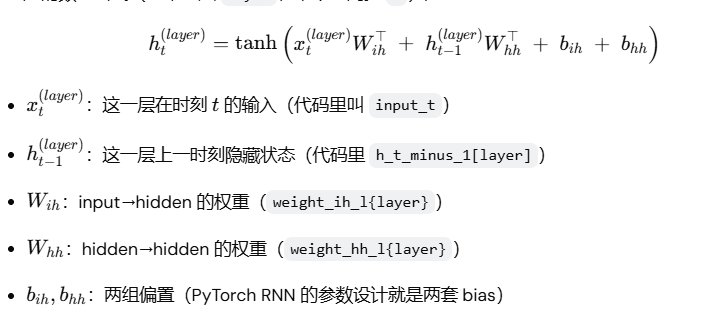